In [1]:
from generate import *
import numpy as np
from UMRtools import *
import time
import shutil
np.set_printoptions(threshold=np.inf)  #使输出数据完整显示
import warnings
warnings.filterwarnings('ignore')

lum in LMS = [0.45436904 0.47353315 0.0720978 ]
[[1.31265115 0.37916654 0.17658182]
 [0.37916654 0.43588297 0.06613005]
 [0.17658182 0.06613005 1.03101131]]
[[10.82668925 -2.48855249  0.0461736 ]
 [-2.48855249  1.38614356 -0.12768065]
 [ 0.0461736  -0.12768065  1.15767798]]
18.53509145317477
0.012775991216413523
range_deg = 0.034479770809412, buffer_deg = 0.038327973649240565
UMRtools verison: v1.2


In [2]:
#生成grating
def Generate_Gratings(C,P,SF,D,frameRate,size):
    '''
    C:contrast,范围在[0,0.5]
    P:#相位,范围[0,2pi)
    SF:spatial frequency,建议范围在10到40之间
    D:方向,范围[0,pi]
    frameRate:帧率（一秒几帧，=1就是静止的,>1就是动的)
    size:图片大小
    '''
    mk_path(gratings_path)
    generate_input(gratings_path,C,P,SF,D,frameRate,size)
    #获取.cfg文件fStimulus对应的文件名    
    fStimulus=Get_fStimulus_Name(gratings_path,size)
    return fStimulus
   

In [4]:
#运行代码并记录时间
def Run_Our_Model(C,P,SF,D,frameRate,size,Simulation_duration=1,fixd=True):
    '''
    固定使用config文件为minimal.cfg
    Simulation_duration:模拟时长(s),默认为1s
    log_on:是否打印一些中间值
    fixd:是否固定fStimulus,如果不固定，每次都会生成grating并修改fStimulus,固定的话手动输入固定为哪个
    '''
    log_on=True
    if fixd:
        fStimulus='static_color-grid_size_64.bin'
    else:
        #生成文件并复制到resource文件夹下
        fStimulus=Generate_Gratings(C,P,SF,D,frameRate,size)[0]
        fStimulus_path = gratings_path+fStimulus
        shutil.copy(fStimulus_path, RESOURCE_DIR)
    if log_on:
        print(f"fStimulus={RESOURCE_DIR}{fStimulus}")
        file_name = os.path.splitext(fStimulus)[0]
        cfg_file_path = os.path.join(gratings_path, file_name + "_cfg.bin")
        sf, ori, phase, contrast=read_grating_cfg(cfg_file_path)
        print(f"sf={sf},ori={ori},phase={phase},contrast={contrast}")

    #更改cfg文件的值   
    with open(f"{SRC_DIR}/minimal.cfg", 'r') as file:
    # 读取文件的每一行，并用列表保存
        lines = file.readlines()
        for i in range(len(lines)):
            if "nt =" in lines[i] and "#nt =" not in lines[i] and lines[i][0]=='n':
                lines[i] = f"nt = {int(8000*Simulation_duration)} \n"
                if log_on:
                    print(f"changed nt = {int(8000*Simulation_duration)}") 
            if "fStimulus =" in lines[i] and "#fStimulus =" not in lines[i]:
                lines[i] = f"fStimulus = {fStimulus} \n"
                if log_on:
                    print(f"changed fStimulus = {fStimulus}") 
            if "frameRate =" in lines[i] and "#frameRate =" not in lines[i]:
                lines[i] = f"frameRate = {frameRate} \n"
                if log_on:
                    print(f"changed frameRate = {frameRate}")     
        with open(f"{SRC_DIR}/minimal.cfg", 'w') as file:
            # 将修改后的行重新写入到文件中
            file.writelines(lines)

    start_time = time.time()
    os.system(f'cd {PATCHFAST_DIR} && {BIN_DIR}patch_fast -c {SRC_DIR}minimal.cfg > {model_log_path}{now_time_str()}.log')
    LGN_spike_time,fr=read_spike(f"{PATCHFAST_DIR}sample_spikeCount-merge_test_1.bin")
    #LGN_spike_time:[521,8000], fr:[3840,1]
    LGN_spike_time = np.floor(LGN_spike_time).astype(int)
    end_time = time.time()
    total_time = round((end_time - start_time),3)
    print(f"pixel为 {size} 时运行时间为 {total_time:.2f} 秒")
    lgn_mean_fr = np.mean(np.sum(LGN_spike_time, axis=1)/Simulation_duration, axis=0)
    v1_mean_fr = np.mean(fr)
    print(LGN_spike_time.shape,fr.shape)
    return lgn_mean_fr,v1_mean_fr,total_time
    

In [5]:
C=np.array([0.45])
P=np.array([0.5*np.pi])
SF = np.arange(36,40,10)#36
D = np.array([np.pi/6])  # 方向范围[0,pi]
frameRate=1
sizes=[16,32,64,80,128,200,256]
# size=64
# times=[1,2,3,4,5,10,15,20]
repeat=10
lgn_mean_fr=[]
v1_mean_fr=[]
run_time=[]
for size in sizes:
    for i in range(repeat):
        lgn_mean_fr0,v1_mean_fr0,total_time=Run_Our_Model(C,P,SF,D,frameRate,size,Simulation_duration=1,fixd=False)
        lgn_mean_fr.append(lgn_mean_fr0)
        v1_mean_fr.append(v1_mean_fr0)
        run_time.append(total_time)
with open('pixel_time.bin', 'wb') as f:
    np.save(f,np.array(sizes))
    np.save(f, lgn_mean_fr) #(8,10)
    np.save(f, v1_mean_fr)
    np.save(f, run_time)

16 degree per pixel
crest in sRGB: [ 1.5214511  -1.83242368  0.72781358]
valley in sRGB: [-18.30753009   1.0386155    0.67997673]
0.009100968057331571 degree per pixel
ecc = 0.034479770809412, buffer_ecc = 0.038327973649240565
1
adjusted to 1 frames in total
sharpness=1.0
it: 0
sRGB space is not enough to represent the color
(array([-18.28771929,  -1.83163078,   0.67999573]), array([1.52140069, 1.03841998, 0.7278113 ]))
fStimulus=/home/zhaobenyan/model/resource/static_color-grid_size_16.bin
sf=36.0,ori=30.0,phase=90.0,contrast=0.44999998807907104
changed fStimulus = static_color-grid_size_16.bin
changed frameRate = 1
changed nt = 8000
pixel为 16 时运行时间为 6.79 秒
(512, 8000) (3840,)
16 degree per pixel
crest in sRGB: [ 1.5214511  -1.83242368  0.72781358]
valley in sRGB: [-18.30753009   1.0386155    0.67997673]
0.009100968057331571 degree per pixel
ecc = 0.034479770809412, buffer_ecc = 0.038327973649240565
1
adjusted to 1 frames in total
sharpness=1.0
it: 0
sRGB space is not enough to repres

In [44]:
# 从二进制文件中加载数组
with open('pixel_time.bin', 'rb') as f:
    sizes = np.load(f)
    lgn_fr = np.load(f)
    v1_fr = np.load(f)
    run_time = np.load(f)
lgn_fr_mean = np.mean(np.array(lgn_fr).reshape(len(sizes),repeat, -1),axis=1) #(8,10)-->(8,)
v1_fr_mean = np.mean(np.array(v1_fr).reshape(len(sizes),repeat, -1),axis=1)
lgn_fr_std = np.std(np.array(lgn_fr).reshape(len(sizes),repeat, -1),axis=1)
v1_fr_std = np.std(np.array(v1_fr).reshape(len(sizes),repeat, -1),axis=1)
run_time_mean = np.mean(np.array(run_time).reshape(len(sizes),repeat, -1),axis=1)
print(sizes.shape)
print(lgn_fr_std)
print(v1_fr_std)

(7,)
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.00204456]
 [0.0041804 ]
 [0.00555665]
 [0.00594275]
 [0.00418947]
 [0.00739643]
 [0.0052579 ]]


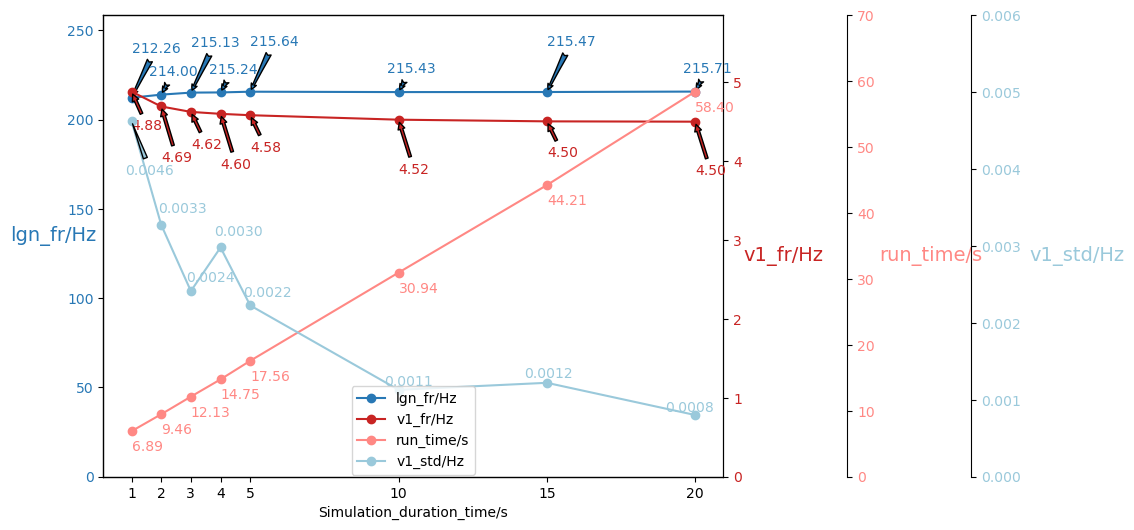

In [43]:
import matplotlib.pyplot as plt

# 为了方便，我们将所有向量转换为一维数组
sizes = sizes.flatten()
lgn_fr_vector = lgn_fr_mean.flatten()
v1_fr_vector = v1_fr_mean.flatten()
lgn_std_vector = lgn_fr_std.flatten()
v1_std_vector = v1_fr_std.flatten()
run_time_vector = run_time_mean.flatten()

#颜色
# color=['#8ECFC9','#FFBE7A','#FA7F6F','#82B0D2','#BEB8DC','#E7DAD2']
color=['#2878b5','#c82423','#ff8884','#9ac9db','#f8ac8c',]

# 创建一个新的图形
fig, ax = plt.subplots(figsize=(8, 6))
plt.xticks(sizes)

# 创建第一个纵坐标
ax.set_xlabel('Simulation_duration_time/s')
ax.set_ylabel('lgn_fr/Hz', fontsize=14, labelpad=10,color=color[0]).set_rotation(0)
ax.plot(sizes, lgn_fr_vector, color=color[0], marker='o')
ax.tick_params(axis='y', labelcolor=color[0])
ax.set_ylim([0, np.max(lgn_fr_vector)*1.2])

# 创建第二个纵坐标
ax2 = ax.twinx()
ax2.set_ylabel('v1_fr/Hz', fontsize=14, labelpad=30,color=color[1]).set_rotation(0)
ax2.plot(sizes, v1_fr_vector, color=color[1], marker='o')
ax2.tick_params(axis='y', labelcolor=color[1])
ax2.set_ylim([0, np.max(v1_fr_vector)*1.2])

# 创建第三个纵坐标
ax3 = ax.twinx()
ax3.spines.right.set_position(('axes', 1.2))
ax3.set_ylabel('run_time/s', fontsize=14, labelpad=40,color=color[2]).set_rotation(0)
ax3.plot(sizes, run_time_vector, color=color[2], marker='o')
ax3.tick_params(axis='y', labelcolor=color[2])
ax3.set_ylim([0, np.max(run_time_vector)*1.2])

# # 创建第四个纵坐标
# ax4 = ax.twinx()
# ax4.spines.right.set_position(('axes', 1.2))
# ax4.set_ylabel('lgn_std/Hz', fontsize=14, labelpad=40,color='yellow').set_rotation(0)
# ax4.plot(sizes, lgn_std_vector, color='yellow', marker='o')
# ax4.tick_params(axis='y', labelcolor='yellow')
# ax4.set_ylim([0, np.max(lgn_std_vector)+0.1])
# # ax4.tick_params(labelright=False)  #隐藏纵坐标轴

# 创建第五个纵坐标
ax5 = ax.twinx()
ax5.spines.right.set_position(('axes', 1.4))
ax5.set_ylabel('v1_std/Hz', fontsize=14, labelpad=40,color=color[3]).set_rotation(0)
ax5.plot(sizes, v1_std_vector, color=color[3], marker='o')
ax5.tick_params(axis='y', labelcolor=color[3])
ax5.set_ylim([0, np.max(v1_std_vector)*1.3])
# ax5.tick_params(labelright=False)

# 显示每个点的值
for i in range(len(sizes)):

    if i % 2 == 0:
        ax.annotate(f"{lgn_fr_vector[i]:.2f}", (sizes[i], lgn_fr_vector[i]), xytext=(sizes[i], lgn_fr_vector[i]*1.12),arrowprops=dict(facecolor=color[0], arrowstyle='fancy'),color=color[0])
        ax2.annotate(f"{v1_fr_vector[i]:.2f}", (sizes[i], v1_fr_vector[i]), xytext=(sizes[i], v1_fr_vector[i]*0.9),arrowprops=dict(facecolor=color[1], arrowstyle='simple'),color=color[1])
    else:
        ax.annotate(f"{lgn_fr_vector[i]:.2f}", (sizes[i], lgn_fr_vector[i]), xytext=(sizes[i]-0.4, lgn_fr_vector[i]*1.05),arrowprops=dict(facecolor=color[0], arrowstyle='fancy'),color=color[0])
        ax2.annotate(f"{v1_fr_vector[i]:.2f}", (sizes[i], v1_fr_vector[i]), xytext=(sizes[i], v1_fr_vector[i]*0.85),arrowprops=dict(facecolor=color[1], arrowstyle='simple'),color=color[1])

    ax3.annotate(f"{run_time_vector[i]:.2f}", (sizes[i], run_time_vector[i]), xytext=(sizes[i], run_time_vector[i]-3),color=color[2])

    # ax4.annotate(f"{lgn_std_vector[i]:.2f}", (sizes[i], lgn_std_vector[i]), xytext=(sizes[i], lgn_std_vector[i]),color='yellow')
    if i==0:
        ax5.annotate(f"{v1_std_vector[i]:.4f}", (sizes[i], v1_std_vector[i]), xytext=(sizes[i]*0.8, v1_std_vector[i]*0.85),arrowprops=dict(facecolor=color[3], arrowstyle='wedge'),color=color[3])
    else:
        ax5.annotate(f"{v1_std_vector[i]:.4f}", (sizes[i], v1_std_vector[i]), xytext=(sizes[i]*0.95, v1_std_vector[i]*1.05),color=color[3])

# 显示图例
legend_labels = ['lgn_fr/Hz', 'v1_fr/Hz', 'run_time/s','v1_std/Hz']
plt.legend([ax.get_lines()[0], ax2.get_lines()[0], ax3.get_lines()[0],ax5.get_lines()[0]], legend_labels, loc='center', bbox_to_anchor=(0.5, 0.1))

# 显示图形
plt.show()

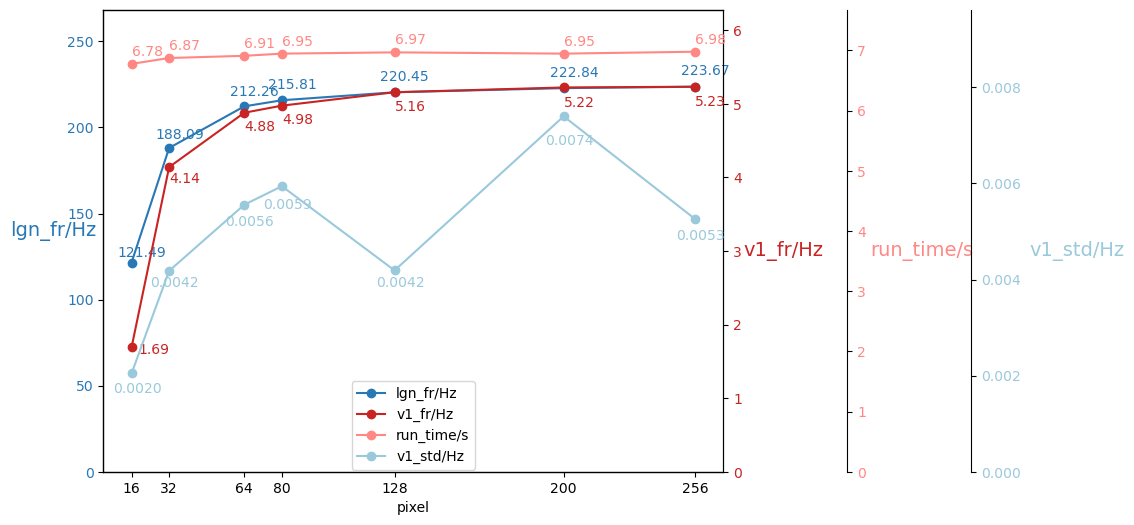

In [69]:
import matplotlib.pyplot as plt

# 为了方便，我们将所有向量转换为一维数组
sizes = sizes.flatten()
lgn_fr_vector = lgn_fr_mean.flatten()
v1_fr_vector = v1_fr_mean.flatten()
lgn_std_vector = lgn_fr_std.flatten()
v1_std_vector = v1_fr_std.flatten()
run_time_vector = run_time_mean.flatten()

#颜色
# color=['#8ECFC9','#FFBE7A','#FA7F6F','#82B0D2','#BEB8DC','#E7DAD2']
color=['#2878b5','#c82423','#ff8884','#9ac9db','#f8ac8c',]

# 创建一个新的图形
fig, ax = plt.subplots(figsize=(8, 6))
plt.xticks(sizes)

# 创建第一个纵坐标
ax.set_xlabel('pixel')
ax.set_ylabel('lgn_fr/Hz', fontsize=14, labelpad=10,color=color[0]).set_rotation(0)
ax.plot(sizes, lgn_fr_vector, color=color[0], marker='o')
ax.tick_params(axis='y', labelcolor=color[0])
ax.set_ylim([0, np.max(lgn_fr_vector)*1.2])

# 创建第二个纵坐标
ax2 = ax.twinx()
ax2.set_ylabel('v1_fr/Hz', fontsize=14, labelpad=30,color=color[1]).set_rotation(0)
ax2.plot(sizes, v1_fr_vector, color=color[1], marker='o')
ax2.tick_params(axis='y', labelcolor=color[1])
ax2.set_ylim([0, np.max(v1_fr_vector)*1.2])

# 创建第三个纵坐标
ax3 = ax.twinx()
ax3.spines.right.set_position(('axes', 1.2))
ax3.set_ylabel('run_time/s', fontsize=14, labelpad=40,color=color[2]).set_rotation(0)
ax3.plot(sizes, run_time_vector, color=color[2], marker='o')
ax3.tick_params(axis='y', labelcolor=color[2])
ax3.set_ylim([0, np.max(run_time_vector)*1.1])

# # 创建第四个纵坐标
# ax4 = ax.twinx()
# ax4.spines.right.set_position(('axes', 1.2))
# ax4.set_ylabel('lgn_std/Hz', fontsize=14, labelpad=40,color='yellow').set_rotation(0)
# ax4.plot(sizes, lgn_std_vector, color='yellow', marker='o')
# ax4.tick_params(axis='y', labelcolor='yellow')
# ax4.set_ylim([0, np.max(lgn_std_vector)+0.1])
# # ax4.tick_params(labelright=False)  #隐藏纵坐标轴

# 创建第五个纵坐标
ax5 = ax.twinx()
ax5.spines.right.set_position(('axes', 1.4))
ax5.set_ylabel('v1_std/Hz', fontsize=14, labelpad=40,color=color[3]).set_rotation(0)
ax5.plot(sizes, v1_std_vector, color=color[3], marker='o')
ax5.tick_params(axis='y', labelcolor=color[3])
ax5.set_ylim([0, np.max(v1_std_vector)*1.3])
# ax5.tick_params(labelright=False)

# 显示每个点的值
for i in range(len(sizes)):

    ax.annotate(f"{lgn_fr_vector[i]:.2f}", (sizes[i], lgn_fr_vector[i]), xytext=(sizes[i]-6, lgn_fr_vector[i]*1.03),color=color[0])

    ax3.annotate(f"{run_time_vector[i]:.2f}", (sizes[i], run_time_vector[i]), xytext=(sizes[i], run_time_vector[i]*1.02),color=color[2])

    # ax4.annotate(f"{lgn_std_vector[i]:.2f}", (sizes[i], lgn_std_vector[i]), xytext=(sizes[i], lgn_std_vector[i]),color='yellow')
    if i==0:
        ax2.annotate(f"{v1_fr_vector[i]:.2f}", (sizes[i], v1_fr_vector[i]), xytext=(sizes[i]+3, v1_fr_vector[i]*0.95),color=color[1])
        ax5.annotate(f"{v1_std_vector[i]:.4f}", (sizes[i], v1_std_vector[i]), xytext=(sizes[i]-8, v1_std_vector[i]*0.8),color=color[3])
    else:
        ax2.annotate(f"{v1_fr_vector[i]:.2f}", (sizes[i], v1_fr_vector[i]), xytext=(sizes[i], v1_fr_vector[i]*0.95),color=color[1])
        ax5.annotate(f"{v1_std_vector[i]:.4f}", (sizes[i], v1_std_vector[i]), xytext=(sizes[i]-8, v1_std_vector[i]*0.92),color=color[3])

# 显示图例
legend_labels = ['lgn_fr/Hz', 'v1_fr/Hz', 'run_time/s','v1_std/Hz']
plt.legend([ax.get_lines()[0], ax2.get_lines()[0], ax3.get_lines()[0],ax5.get_lines()[0]], legend_labels, loc='center', bbox_to_anchor=(0.5, 0.1))

# 显示图形
plt.show()

In [7]:
from PIL import Image

# 设置每个小图片的宽高
width, height = 256, 256

# 创建一张新的大图片
result = Image.new('RGB', (width * 4, height*2))

# 循环遍历每张小图片，并将其粘贴到大图片上
for i, size in enumerate([16,32,64,80,128,200,256]):
    # 打开当前小图片
    img = Image.open(f'/home/zhaobenyan/model/data_save/gratings/static_color-grid_size_{size}.png')
    # 缩放小图片到指定大小
    img = img.resize((width, height))
    # 计算当前小图片应该被粘贴到大图片的哪个位置
    x = (i % 4) * width
    y = (i // 4) * height
    # 将当前小图片粘贴到大图片上
    result.paste(img, (x, y))

# 保存结果图片
result.save('/home/zhaobenyan/model/data_save/gratings/static_color-grid_combined.png')
